In [1]:
import os

# This suppresses most of TensorFlow's logging output, keeping the console clean.
# Levels: 0 = all logs, 1 = no info, 2 = no warnings, 3 = no errors.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import math
import numpy as np
import matplotlib.pyplot as plt

import json
import pandas as pd

import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv1D, GlobalAveragePooling1D, 
    Concatenate, Add, LayerNormalization, MultiHeadAttention, BatchNormalization
)
from tensorflow.keras.models import Model
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    median_absolute_error, 
    explained_variance_score
)

from geexhp import datavis as dvis
dvis.configure_matplotlib()

In [2]:
def compute_normalization_stats(train_tfrecord_path):
    stats = {
        'inputs': {'UV': {'sum': 0., 'sq_sum': 0., 'count': 0},
                    'Vis': {'sum': 0., 'sq_sum': 0., 'count': 0},
                    'NIR': {'sum': 0., 'sq_sum': 0., 'count': 0}},
        'outputs': {key: {'sum': 0., 'sq_sum': 0., 'count': 0} 
                   for key in ['OBJECT-RADIUS-REL-EARTH', 'OBJECT-GRAVITY', 
                                'ATMOSPHERE-TEMPERATURE', 'ATMOSPHERE-PRESSURE',
                                'C2H6', 'CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O', 'O2', 'O3']}
    }

    def parse_fn(example):
        features = {
            # Inputs
            'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
            'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
            'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),

            # Outputs
            'OBJECT-RADIUS-REL-EARTH': tf.io.FixedLenFeature([], tf.float32),
            'OBJECT-GRAVITY': tf.io.FixedLenFeature([], tf.float32),
            'ATMOSPHERE-TEMPERATURE': tf.io.FixedLenFeature([], tf.float32),
            'ATMOSPHERE-PRESSURE': tf.io.FixedLenFeature([], tf.float32),
            'C2H6': tf.io.FixedLenFeature([], tf.float32),
            'CH4': tf.io.FixedLenFeature([], tf.float32),
            'CO': tf.io.FixedLenFeature([], tf.float32),
            'CO2': tf.io.FixedLenFeature([], tf.float32),
            'H2O': tf.io.FixedLenFeature([], tf.float32),
            'N2': tf.io.FixedLenFeature([], tf.float32),
            'N2O': tf.io.FixedLenFeature([], tf.float32),
            'O2': tf.io.FixedLenFeature([], tf.float32),
            'O3': tf.io.FixedLenFeature([], tf.float32)
        }
        return tf.io.parse_single_example(example, features)

    dataset = tf.data.TFRecordDataset(train_tfrecord_path)
    dataset = dataset.map(parse_fn)
    
    for batch in dataset.batch(1000):  # Process in chunks
        # Inputs
        for region in ['UV', 'Vis', 'NIR']:
            key = f'NOISY_ALBEDO_B-{region}'
            data = tf.sparse.to_dense(batch[key]).numpy()
            stats['inputs'][region]['sum'] += np.sum(data)
            stats['inputs'][region]['sq_sum'] += np.sum(data**2)
            stats['inputs'][region]['count'] += data.size
            
        # Outputs 
        for key in stats['outputs']:
            data = batch[key].numpy()
            stats['outputs'][key]['sum'] += np.sum(data)
            stats['outputs'][key]['sq_sum'] += np.sum(data**2)
            stats['outputs'][key]['count'] += data.size

    final_stats = {}
    
    # Input stats
    final_stats['inputs'] = {}
    for region in ['UV', 'Vis', 'NIR']:
        mean = stats['inputs'][region]['sum'] / stats['inputs'][region]['count']
        std = np.sqrt((stats['inputs'][region]['sq_sum'] / stats['inputs'][region]['count']) - mean**2)
        final_stats['inputs'][region] = {'mean': float(mean), 'std': float(std)}
    
    # Output stats
    final_stats['outputs'] = {}
    for key in stats['outputs']:
        mean = stats['outputs'][key]['sum'] / stats['outputs'][key]['count']
        std = np.sqrt((stats['outputs'][key]['sq_sum'] / stats['outputs'][key]['count']) - mean**2)
        final_stats['outputs'][key] = {'mean': float(mean), 'std': float(std)}

    with open('../data/normalization_stats.json', 'w') as f:
        json.dump(final_stats, f)
        
    return final_stats

# Run this once on training data
# stats = compute_normalization_stats("../data/train.tfrecord")

In [3]:
# Load statistics from Phase 1
with open('../data/normalization_stats.json') as f:
    stats = json.load(f)

# Create lookup dictionaries for TF operations
input_stats = {
    'UV': (stats['inputs']['UV']['mean'], stats['inputs']['UV']['std']),
    'Vis': (stats['inputs']['Vis']['mean'], stats['inputs']['Vis']['std']),
    'NIR': (stats['inputs']['NIR']['mean'], stats['inputs']['NIR']['std'])
}

output_stats = {
    key: (stats['outputs'][key]['mean'], stats['outputs'][key]['std'])
    for key in stats['outputs']
}

In [4]:
def parse_example(example_proto, input_stats, output_stats):
    raw_input_features = {
        'NOISY_ALBEDO_B-NIR': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-UV': tf.io.VarLenFeature(tf.float32),
        'NOISY_ALBEDO_B-Vis': tf.io.VarLenFeature(tf.float32),
    }

    raw_output_features = {
        "OBJECT-RADIUS-REL-EARTH": tf.io.FixedLenFeature([], tf.float32),
        "OBJECT-GRAVITY": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-TEMPERATURE": tf.io.FixedLenFeature([], tf.float32),
        "ATMOSPHERE-PRESSURE": tf.io.FixedLenFeature([], tf.float32),

        # 'Earth_type' : tf.io.FixedLenFeature([], tf.string),

        'C2H6': tf.io.FixedLenFeature([], tf.float32),
        'CH4': tf.io.FixedLenFeature([], tf.float32),
        'CO': tf.io.FixedLenFeature([], tf.float32),
        'CO2': tf.io.FixedLenFeature([], tf.float32),
        'H2O': tf.io.FixedLenFeature([], tf.float32),
        'N2': tf.io.FixedLenFeature([], tf.float32),
        'N2O': tf.io.FixedLenFeature([], tf.float32),
        'O2': tf.io.FixedLenFeature([], tf.float32),
        'O3': tf.io.FixedLenFeature([], tf.float32)
    }

    all_features = {**raw_input_features, **raw_output_features}
    parsed = tf.io.parse_single_example(example_proto, all_features)

    normalized_inputs = {}
    for region in ['UV', 'Vis', 'NIR']:
        spectrum = parsed[f'NOISY_ALBEDO_B-{region}']
        if isinstance(spectrum, tf.SparseTensor):
            spectrum = tf.sparse.to_dense(spectrum, default_value=0.0)
        
        mean = input_stats[region][0]
        std = input_stats[region][1]
        normalized = (spectrum - mean) / std
        
        if region == 'UV':
            normalized = tf.reshape(normalized, [8, 1])
        elif region == 'Vis':
            normalized = tf.reshape(normalized, [94, 1])
        elif region == 'NIR':
            normalized = tf.reshape(normalized, [49, 1])
            
        normalized_inputs[f'NOISY_ALBEDO_B-{region}'] = normalized

    processed_outputs = {}
    
    radius = parsed['OBJECT-RADIUS-REL-EARTH']
    processed_outputs['OBJECT-RADIUS-REL-EARTH'] = (radius - output_stats['OBJECT-RADIUS-REL-EARTH'][0]) / output_stats['OBJECT-RADIUS-REL-EARTH'][1]
    
    gravity = parsed['OBJECT-GRAVITY']
    processed_outputs['OBJECT-GRAVITY'] = (gravity - output_stats['OBJECT-GRAVITY'][0]) / output_stats['OBJECT-GRAVITY'][1]
    
    temperature = parsed['ATMOSPHERE-TEMPERATURE']
    processed_outputs['ATMOSPHERE-TEMPERATURE'] = (temperature - output_stats['ATMOSPHERE-TEMPERATURE'][0]) / output_stats['ATMOSPHERE-TEMPERATURE'][1]
    
    pressure = parsed['ATMOSPHERE-PRESSURE']
    processed_outputs['ATMOSPHERE-PRESSURE'] = (pressure - output_stats['ATMOSPHERE-PRESSURE'][0]) / output_stats['ATMOSPHERE-PRESSURE'][1]
    
    for chem in ['C2H6', 'CH4', 'CO', 'CO2', 'H2O', 'N2', 'N2O', 'O2', 'O3']:
        chem_value = parsed[chem]
        processed_outputs[f'{chem}'] = (chem_value - output_stats[f'{chem}'][0]) /  output_stats[f'{chem}'][1]

    # processed_outputs['Earth_type'] = parsed['Earth_type']
    # processed_outputs["NOISE_B-NIR"] = parsed["NOISE_B-NIR"]

    return normalized_inputs, processed_outputs

In [5]:
def read_tfrecord(file_path, input_stats, output_stats, 
                    batch_size=256, shuffle_buffer=None, repeat=False):
    
    dataset = tf.data.TFRecordDataset(file_path, num_parallel_reads=tf.data.AUTOTUNE)

    if shuffle_buffer is not None and shuffle_buffer > 0:
        dataset = dataset.shuffle(buffer_size=shuffle_buffer)

    # Parse the dataset after shuffling
    parsed_dataset = dataset.map(
        lambda x: parse_example(x, input_stats, output_stats), 
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Repeat the dataset for multiple epochs
    if repeat:
        parsed_dataset = parsed_dataset.repeat()

    # Batch after shuffling and parsing
    parsed_dataset = parsed_dataset.batch(batch_size, drop_remainder=False)
    parsed_dataset = parsed_dataset.prefetch(tf.data.AUTOTUNE)
    
    return parsed_dataset

In [6]:
train_ds = read_tfrecord("../data/train.tfrecord", input_stats, output_stats, shuffle_buffer=800000, repeat=True)
val_ds = read_tfrecord("../data/val.tfrecord", input_stats, output_stats, shuffle_buffer=90000, repeat=True)
test_ds = read_tfrecord("../data/test.tfrecord", input_stats, output_stats)

In [7]:
batch = next(iter(train_ds.take(1)))

print("\n## Input Shapes:")
for k,v in batch[0].items():
    print(f"> {k}: {v.shape}") 

print("\n## Output Ranges (standardized):")
for k,v in batch[1].items():
    if k != 'Earth_type':
        print(f"> {k}: {tf.reduce_mean(v):.3f} ± {tf.math.reduce_std(v):.6f}")


## Input Shapes:
> NOISY_ALBEDO_B-UV: (256, 8, 1)
> NOISY_ALBEDO_B-Vis: (256, 94, 1)
> NOISY_ALBEDO_B-NIR: (256, 49, 1)

## Output Ranges (standardized):
> OBJECT-RADIUS-REL-EARTH: -0.017 ± 0.981726
> OBJECT-GRAVITY: -0.019 ± 0.983238
> ATMOSPHERE-TEMPERATURE: -0.050 ± 0.986680
> ATMOSPHERE-PRESSURE: -0.025 ± 0.980283
> C2H6: 0.017 ± 1.163935
> CH4: 0.038 ± 1.123557
> CO: -0.022 ± 0.854251
> CO2: -0.033 ± 0.875685
> H2O: 0.069 ± 1.283269
> N2: -0.031 ± 1.018700
> N2O: -0.017 ± 0.790182
> O2: 0.033 ± 1.036563
> O3: -0.049 ± 0.719142


In [8]:
def plot_spectrum(ds, sample_number):
    for batch in ds.take(1):
        pass

    x1 = batch[0]['NOISY_ALBEDO_B-UV'][sample_number]
    x2 = batch[0]['NOISY_ALBEDO_B-Vis'][sample_number]
    x3 = batch[0]['NOISY_ALBEDO_B-NIR'][sample_number]

    UV = np.array([0.2       , 0.22857143, 0.26122449, 0.29854227, 0.34119117,
       0.38993277, 0.44563745, 0.50929994])
    VIS = np.array([0.515     , 0.51867857, 0.52238342, 0.52611473, 0.52987269,
       0.5336575 , 0.53746934, 0.5413084 , 0.54517489, 0.549069  ,
       0.55299092, 0.55694085, 0.560919  , 0.56492557, 0.56896075,
       0.57302475, 0.57711779, 0.58124006, 0.58539177, 0.58957314,
       0.59378438, 0.5980257 , 0.60229731, 0.60659943, 0.61093229,
       0.61529609, 0.61969106, 0.62411742, 0.62857541, 0.63306523,
       0.63758712, 0.64214132, 0.64672804, 0.65134753, 0.65600001,
       0.66068572, 0.66540491, 0.6701578 , 0.67494464, 0.67976568,
       0.68462114, 0.6895113 , 0.69443638, 0.69939664, 0.70439233,
       0.7094237 , 0.71449101, 0.71959452, 0.72473448, 0.72991116,
       0.73512481, 0.7403757 , 0.7456641 , 0.75099027, 0.75635448,
       0.76175702, 0.76719814, 0.77267812, 0.77819725, 0.78375581,
       0.78935406, 0.7949923 , 0.80067082, 0.8063899 , 0.81214983,
       0.8179509 , 0.8237934 , 0.82967764, 0.83560391, 0.84157251,
       0.84758374, 0.85363791, 0.85973532, 0.86587629, 0.87206112,
       0.87829013, 0.88456363, 0.89088194, 0.89724539, 0.90365428,
       0.91010895, 0.91660973, 0.92315694, 0.92975092, 0.936392  ,
       0.94308052, 0.9498168 , 0.95660121, 0.96343408, 0.97031575,
       0.97724657, 0.98422691, 0.9912571 , 0.99833751])
    NIR = np.array([1.01      , 1.02442857, 1.03906327, 1.05390703, 1.06896284,
       1.08423374, 1.09972279, 1.11543312, 1.13136788, 1.14753028,
       1.16392356, 1.18055104, 1.19741606, 1.214522  , 1.23187232,
       1.24947049, 1.26732007, 1.28542464, 1.30378785, 1.32241339,
       1.34130501, 1.36046651, 1.37990175, 1.39961463, 1.41960913,
       1.43988926, 1.4604591 , 1.48132281, 1.50248456, 1.52394862,
       1.54571932, 1.56780102, 1.59019818, 1.6129153 , 1.63595694,
       1.65932776, 1.68303244, 1.70707576, 1.73146256, 1.75619774,
       1.78128628, 1.80673322, 1.8325437 , 1.85872289, 1.88527608,
       1.91220859, 1.93952586, 1.96723337, 1.9953367 ])

    plt.plot(UV, x1, label='UV')
    plt.plot(VIS, x2, label='Vis')
    plt.plot(NIR, x3, label='NIR')
    plt.legend()
    plt.show()

    for output in batch[1].keys():
        print(f'> {output}: \t {batch[1][output][sample_number]}')

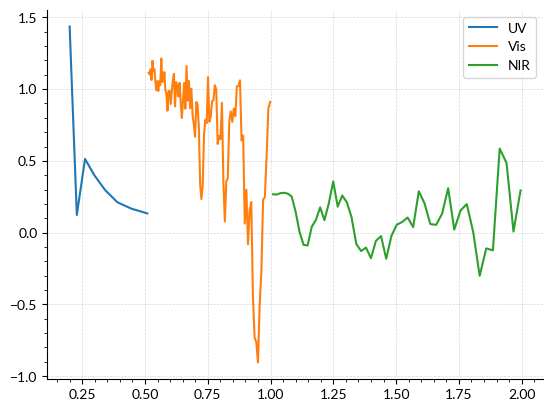

> OBJECT-RADIUS-REL-EARTH: 	 -0.1145441085100174
> OBJECT-GRAVITY: 	 -0.1832723468542099
> ATMOSPHERE-TEMPERATURE: 	 -0.4254114627838135
> ATMOSPHERE-PRESSURE: 	 -0.27717819809913635
> C2H6: 	 -0.24059292674064636
> CH4: 	 -0.363718718290329
> CO: 	 -0.2522239685058594
> CO2: 	 -0.03522925078868866
> H2O: 	 -0.05747006833553314
> N2: 	 0.534133791923523
> N2O: 	 -0.23068712651729584
> O2: 	 -0.4752453565597534
> O3: 	 -0.23128028213977814


In [9]:
plot_spectrum(train_ds, 0)

In [10]:
def transformer_block(x, num_heads, ff_dim, dropout_rate):
    # Multi-Head Self-Attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = Add()([x, attn_output])
    out1 = LayerNormalization()(out1)
    
    # Feed-forward network
    ffn = Dense(
        ff_dim,
        activation=tf.nn.swish, 
        kernel_initializer='he_normal'
    )(out1)
    ffn = Dense(
        x.shape[-1],
        kernel_initializer='he_normal'
    )(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    out2 = Add()([out1, ffn])
    out2 = LayerNormalization()(out2)
    return out2

In [11]:
def build_branch(input_tensor, hp, branch_name):
    d_model = hp.Int(f'{branch_name}_d_model', min_value=8, max_value=24, step=8)
    
    # First Conv1D layer
    x = Conv1D(
        filters=d_model,
        kernel_size=1,
        padding='same',
        activation=tf.nn.swish, 
        kernel_initializer='he_normal',
    )(input_tensor)
    
    # Second Conv1D for feature extraction with fewer filters
    conv_filters = hp.Int(f'{branch_name}_conv_filters', min_value=8, max_value=24, step=8)
    conv_kernel  = hp.Choice(f'{branch_name}_conv_kernel', values=[3, 5])
    x = Conv1D(
        filters=conv_filters,
        kernel_size=conv_kernel,
        padding='same',
        activation=tf.nn.swish,
        kernel_initializer='he_normal',
    )(x)
    x = BatchNormalization()(x)
    
    # Use a single transformer block with fewer heads and a smaller feed-forward dimension
    transformer_blocks = 1  # fixed to 1 block
    num_heads = hp.Choice(f'{branch_name}_num_heads', values=[1, 2])
    ff_dim = hp.Int(f'{branch_name}_ff_dim', min_value=8, max_value=24, step=8)
    dropout_rate = hp.Choice(f'{branch_name}_dropout_rate', values=[0.1, 0.2, 0.3])
    
    for _ in range(transformer_blocks):
        # Multi-head self-attention block.
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization()(x)
        
        # Feed-forward block.
        ffn = Dense(
            ff_dim,
            activation=tf.nn.swish,
            kernel_initializer='he_normal'
        )(x)
        ffn = Dense(
            x.shape[-1],
            kernel_initializer='he_normal'
        )(ffn)
        ffn = Dropout(dropout_rate)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization()(x)
    
    return GlobalAveragePooling1D()(x)

In [12]:
def build_model(hp):
    input_uv  = Input(shape=(8, 1), name='NOISY_ALBEDO_B-UV')
    input_vis = Input(shape=(94, 1), name='NOISY_ALBEDO_B-Vis')
    input_nir = Input(shape=(49, 1), name='NOISY_ALBEDO_B-NIR')
    
    # Build branches
    branch_uv   = build_branch(input_uv, hp, branch_name="uv")
    branch_vis  = build_branch(input_vis, hp, branch_name="vis")
    branch_nir  = build_branch(input_nir, hp, branch_name="nir")
    
    concat_input  = Concatenate(axis=1)([input_uv, input_vis, input_nir])
    branch_concat = build_branch(concat_input, hp, branch_name="concat")
    
    merged = Concatenate()([branch_uv, branch_vis, branch_nir, branch_concat])
    
    dense_units  = hp.Int('dense_units', min_value=32, max_value=96, step=32)
    dropout_rate = hp.Choice('shared_dropout_rate', values=[0.1, 0.2, 0.3])
    
    x = Dense(
        dense_units,
        activation=tf.nn.swish,
        kernel_initializer='he_normal',
    )(merged)
    x = Dropout(dropout_rate)(x)
    
    physical_branch = Dense(
        dense_units // 2,
        activation=tf.nn.swish,
        kernel_initializer='he_normal',
    )(x)
    physical_branch = Dropout(dropout_rate)(physical_branch)
    
    chemical_branch = Dense(
        dense_units // 2,
        activation=tf.nn.swish,
        kernel_initializer='he_normal',
    )(x)
    chemical_branch = Dropout(dropout_rate)(chemical_branch)
    
    physical_out = {
        "OBJECT-RADIUS-REL-EARTH": Dense(1, activation='linear', name="OBJECT-RADIUS-REL-EARTH")(physical_branch),
        "OBJECT-GRAVITY": Dense(1, activation='linear', name="OBJECT-GRAVITY")(physical_branch),
        "ATMOSPHERE-TEMPERATURE": Dense(1, activation='linear', name="ATMOSPHERE-TEMPERATURE")(physical_branch),
        "ATMOSPHERE-PRESSURE": Dense(1, activation='linear', name="ATMOSPHERE-PRESSURE")(physical_branch)
    }
    
    chemical_names = [
        "C2H6", "CH4", "CO", "CO2", "H2O", "N2", "N2O", "O2", "O3"
    ]
    chemical_out = {name: Dense(1, activation='linear', name=name)(chemical_branch)
                    for name in chemical_names}
    
    outputs = {**physical_out, **chemical_out}
    
    model = Model(inputs=[input_uv, input_vis, input_nir], outputs=outputs)
    lr = hp.Choice('learning_rate', values=[1e-5, 1e-4, 1e-3, 1e-2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    loss_weights = {
        "OBJECT-RADIUS-REL-EARTH": 1.0,
        "OBJECT-GRAVITY": 1.0,
        "ATMOSPHERE-TEMPERATURE": 1.0,
        "ATMOSPHERE-PRESSURE": 1.0,
        "C2H6": 1.0,
        "CH4": 1.0,
        "CO": 1.0,
        "CO2": 1.0,
        "H2O": 1.0,
        "N2": 1.0,
        "N2O": 1.0,
        "O2": 2.0,
        "O3": 2.0
    }

    losses = {output_name: 'mae' for output_name in loss_weights.keys()}
    
    model.compile(optimizer=optimizer, loss=losses, loss_weights=loss_weights)
    return model

In [13]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=2,
    directory='opt',
    project_name='bayesopt'
)

Reloading Tuner from opt/bayesopt/tuner0.json


In [14]:
TRAIN_SAMPLES = 892073
VAL_SAMPLES = 107422
BATCH_SIZE = 256

steps_per_epoch = math.ceil(TRAIN_SAMPLES / BATCH_SIZE)
validation_steps = math.ceil(VAL_SAMPLES / BATCH_SIZE)

In [15]:
tuner.search(train_ds, epochs=1, validation_data=val_ds, 
                steps_per_epoch=steps_per_epoch, 
                    validation_steps=validation_steps)

In [16]:
# tuner.results_summary()

In [17]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
display(best_hp.values)

Best Hyperparameters:


{'uv_d_model': 8,
 'uv_conv_filters': 16,
 'uv_conv_kernel': 5,
 'uv_num_heads': 1,
 'uv_ff_dim': 16,
 'uv_dropout_rate': 0.3,
 'vis_d_model': 16,
 'vis_conv_filters': 16,
 'vis_conv_kernel': 5,
 'vis_num_heads': 2,
 'vis_ff_dim': 24,
 'vis_dropout_rate': 0.2,
 'nir_d_model': 24,
 'nir_conv_filters': 24,
 'nir_conv_kernel': 5,
 'nir_num_heads': 2,
 'nir_ff_dim': 8,
 'nir_dropout_rate': 0.3,
 'concat_d_model': 24,
 'concat_conv_filters': 16,
 'concat_conv_kernel': 5,
 'concat_num_heads': 2,
 'concat_ff_dim': 24,
 'concat_dropout_rate': 0.1,
 'dense_units': 64,
 'shared_dropout_rate': 0.2,
 'learning_rate': 0.001}

In [18]:
best_model = build_model(best_hp)

In [19]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ NOISY_ALBEDO_B-UV   │ (None, 8, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-Vis  │ (None, 94, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ NOISY_ALBEDO_B-NIR  │ (None, 49, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 151, 1)    │          0 │ NOISY_ALBEDO_B-U… │
│ (Concatenate)       │                   │            │ NOISY_ALBEDO_B-V… │
│                     │                   │            │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 8)      │         16 │ NOISY_ALBEDO_B-U… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 94, 16)    │         32 │ NOISY_ALBEDO_B-V… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 49, 24)    │         48 │ NOISY_ALBEDO_B-N… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 151, 24)   │         48 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 16)     │        656 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 94, 16)    │      1,296 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 49, 24)    │      2,904 │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 151, 16)   │      1,936 │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 8, 16)     │         64 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 16)    │         64 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 24)    │         96 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 151, 16)   │         64 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 16)     │      1,088 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 94, 16)    │      3,232 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 24)    │      1,608 │ batch_normalizat… │
│ (MultiHeadAttentio… │                   │            │ batch_normalizat

 Total params: 28,509 (111.36 KB)

 Trainable params: 28,365 (110.80 KB)

 Non-trainable params: 144 (576.00 B)

In [20]:
epochs = 4

history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
)

Epoch 1/4
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 959s 270ms/step - ATMOSPHERE-PRESSURE_loss: 0.6113 - ATMOSPHERE-TEMPERATURE_loss: 0.7287 - C2H6_loss: 0.2605 - CH4_loss: 0.3458 - CO2_loss: 0.4247 - CO_loss: 0.2737 - H2O_loss: 0.3001 - N2O_loss: 0.2436 - N2_loss: 0.5397 - O2_loss: 0.8458 - O3_loss: 0.4313 - OBJECT-GRAVITY_loss: 0.6131 - OBJECT-RADIUS-REL-EARTH_loss: 0.6053 - loss: 6.2238 - val_ATMOSPHERE-PRESSURE_loss: 0.4394 - val_ATMOSPHERE-TEMPERATURE_loss: 0.6853 - val_C2H6_loss: 0.2480 - val_CH4_loss: 0.2390 - val_CO2_loss: 0.3756 - val_CO_loss: 0.2582 - val_H2O_loss: 0.1991 - val_N2O_loss: 0.2256 - val_N2_loss: 0.4449 - val_O2_loss: 0.6281 - val_O3_loss: 0.2340 - val_OBJECT-GRAVITY_loss: 0.4332 - val_OBJECT-RADIUS-REL-EARTH_loss: 0.4294 - val_loss: 4.8399
Epoch 2/4
3485/3485 ━━━━━━━━━━━━━━━━━━━━ 928s 266ms/step - ATMOSPHERE-PRESSURE_loss: 0.4629 - ATMOSPHERE-TEMPERATURE_loss: 0.6911 - C2H6_loss: 0.2247 - CH4_loss: 0.2701 - CO2_loss: 0.3845 - CO_loss: 0.2341 - H2O_loss: 0.2322 - N2O_loss: 

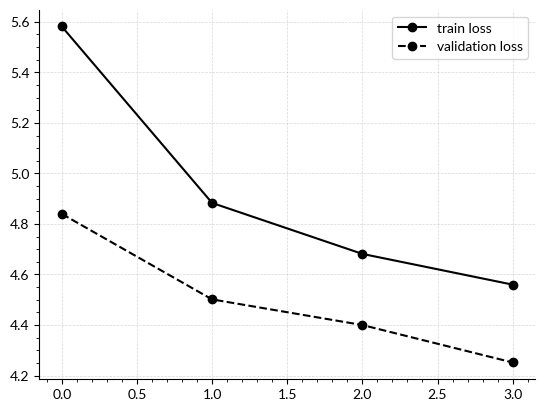

In [22]:
plt.plot(range(epochs), history.history["loss"], marker="o", 
            label="train loss", color="k", linestyle="solid")
plt.plot(range(epochs), history.history["val_loss"], marker="o", 
            label="validation loss", color="k", linestyle="dashed")
plt.legend();

In [23]:
predictions = best_model.predict(test_ds)

342/342 ━━━━━━━━━━━━━━━━━━━━ 32s 90ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [24]:
all_true = {key: [] for key in output_stats.keys()}
for batch_in, batch_out in test_ds:
    for key in output_stats:
        all_true[key].append(batch_out[key].numpy())
for key in all_true:
    all_true[key] = np.concatenate(all_true[key], axis=0)

In [25]:
denorm_pred = {}
denorm_true = {}
for key in output_stats:
    mean_val = output_stats[key][0]
    std_val  = output_stats[key][1]

    y_pred_norm = predictions[key].reshape(-1)
    y_true_norm = all_true[key].reshape(-1)
    
    denorm_pred[key] = y_pred_norm * std_val + mean_val
    denorm_true[key] = y_true_norm * std_val + mean_val

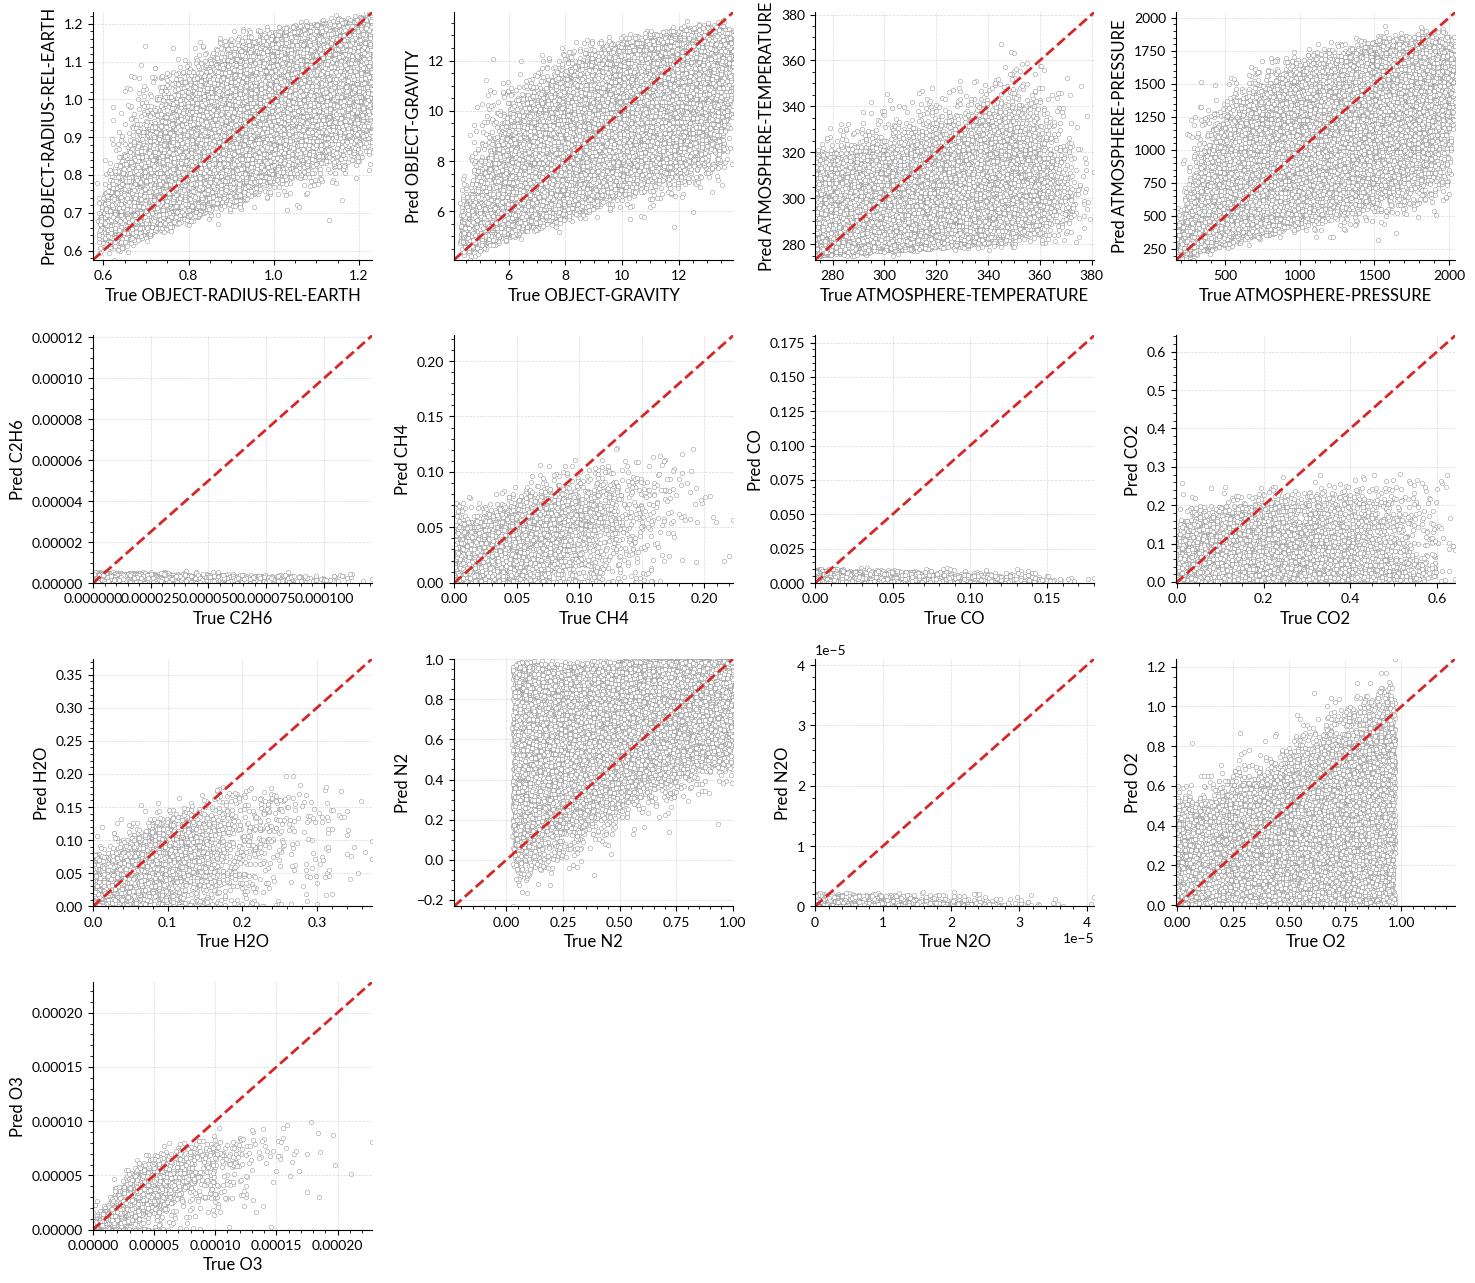

In [26]:
n_keys = len(output_stats.keys())
n_cols = 4  
n_rows = int(np.ceil(n_keys / n_cols)) 

plt.figure(figsize=(15, 13)) 
plt.subplots_adjust(wspace=0.3, hspace=0.4) 

for idx, key in enumerate(output_stats.keys(), 1):
    ax = plt.subplot(n_rows, n_cols, idx)
    
    ax.scatter(denorm_true[key], denorm_pred[key], s=10, edgecolor="gray", color="white", linewidth=0.3)
    
    min_val = min(denorm_true[key].min(), denorm_pred[key].min())
    max_val = max(denorm_true[key].max(), denorm_pred[key].max())
    ax.plot([min_val, max_val], [min_val, max_val], ls="--", color="tab:red", lw=2)
    ax.set(xlim=(min_val, max_val), ylim=(min_val, max_val))
    
    ax.set_xlabel(f"True {key}")
    ax.set_ylabel(f"Pred {key}")
    
for idx in range(n_keys+1, n_rows*n_cols+1):
    plt.subplot(n_rows, n_cols, idx).axis('off')

plt.tight_layout();

In [27]:
metrics_list = []

for key in output_stats:
    y_true = denorm_true[key]
    y_pred = denorm_pred[key]
    
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    med_ae = median_absolute_error(y_true, y_pred)
    exp_var = explained_variance_score(y_true, y_pred)
    
    metrics_list.append({
        "Output": key,
        "R²": r2,
        "Explained Variance": exp_var,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "Median Absolute Error": med_ae
    })

df_metrics = pd.DataFrame(metrics_list)
df_metrics

,Output,R²,Explained Variance,MSE,RMSE,MAE,Median Absolute Error
0,OBJECT-RADIUS-REL-EARTH,0.770960,0.776502,6.242230e-03,0.079008,5.992641e-02,4.661393e-02
1,OBJECT-GRAVITY,0.761365,0.769034,1.465064e+00,1.210398,9.101676e-01,6.991692e-01
2,ATMOSPHERE-TEMPERATURE,0.226708,0.271493,3.228037e+02,17.966740,1.304449e+01,9.223694e+00
3,ATMOSPHERE-PRESSURE,0.732423,0.747281,6.378311e+04,252.553177,1.828133e+02,1.289874e+02
4,C2H6,0.043167,0.078374,4.054800e-11,0.000006,1.432654e-06,2.212198e-08
5,CH4,0.623295,0.627847,9.969236e-05,0.009985,3.099348e-03,2.912828e-04
6,CO,0.054334,0.091533,9.774545e-05,0.009887,2.353938e-03,5.368330e-05
7,CO2,0.262752,0.299531,4.232362e-03,0.065057,2.404185e-02,3.275897e-03
8,H2O,0.613428,0.621538,2.069425e-04,0.014385,3.714320e-03,4.674820e-04
9,N2,0.503770,0.538907,2.800295e-02,0.167341,9.341000e-02,3.450453e-02
